## 🔗  Mount Google Drive & Define Dataset Paths
Mount Google Drive to access datasets and define paths for raw and split data. This is essential to read and write files directly from the cloud.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🧹  Bias Analysis & Manual Dataset Splitting
To mitigate class imbalance, we split the dataset  into train/validation/test (70/15/15) with an equal number of samples for each class.


## 📊  Class Distribution After Dataset Splitting
This visualization shows how the dataset was rebalanced and split to avoid bias during training.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already split. Skipping splitting step.

Class Distribution After Splitting:
  Train - healthy: 1593
  Train - diseased: 1557
  Validation - healthy: 341
  Validation - diseased: 334
  Test - healthy: 343
  Test - diseased: 334


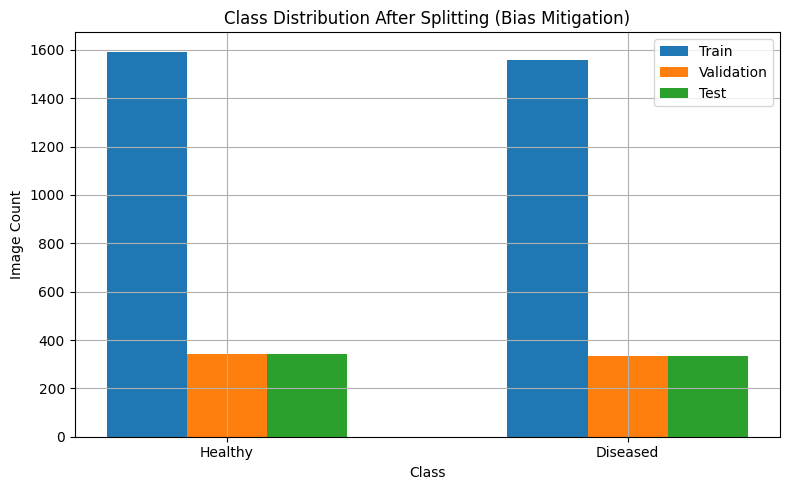

i split the dataset into training, validation, and test sets in a stratified way to mitigate class imbalance and also i have mixed healthy image ffrom ther datset as well to tweak database
This ensures all subsets contain a balanced representation of healthy and diseased samples.
Note: Further data augmentation will be applied dynamically during model training using ImageDataGenerator.


In [3]:
# Mount Google Drive
from google.colab import drive
import os, shutil, random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

# Define paths
dataset_path = '/content/drive/My Drive/datasets/leaves-healthy-or-diseased'
split_path = '/content/drive/My Drive/datasets/leaves-healthy-or-diseased-split'

# Check original dataset folders
healthy_path = os.path.join(dataset_path, 'healthy')
diseased_path = os.path.join(dataset_path, 'diseased')

if not os.path.exists(healthy_path) or not os.path.exists(diseased_path):
    raise FileNotFoundError("Dataset not found. Please upload it to Google Drive.")

# List original files (for splitting)
healthy_images = [f for f in os.listdir(healthy_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
diseased_images = [f for f in os.listdir(diseased_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

# Perform dataset split only if not already done
if not os.path.exists(os.path.join(split_path, 'train')):
    print("\nSplitting dataset into Train / Validation / Test sets...")

    def split_and_copy(images, label):
        random.shuffle(images)
        n = len(images)
        train, val, test = images[:int(0.7*n)], images[int(0.7*n):int(0.85*n)], images[int(0.85*n):]
        for subset, files in zip(['train', 'validation', 'test'], [train, val, test]):
            folder = os.path.join(split_path, subset, label)
            os.makedirs(folder, exist_ok=True)
            for file in files:
                shutil.copy(os.path.join(dataset_path, label, file), os.path.join(folder, file))

    split_and_copy(healthy_images, 'healthy')
    split_and_copy(diseased_images, 'diseased')

    print("Splitting complete. Data saved at:", split_path)
else:
    print("Dataset already split. Skipping splitting step.")

# Count files in each split to display results
def count_images_in_split():
    print("\nClass Distribution After Splitting:")
    counts = {'train': {}, 'validation': {}, 'test': {}}
    for subset in ['train', 'validation', 'test']:
        for cls in ['healthy', 'diseased']:
            folder = os.path.join(split_path, subset, cls)
            count = len([f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
            counts[subset][cls] = count
            print(f"  {subset.title()} - {cls}: {count}")
    return counts

counts = count_images_in_split()

# Plot class distribution after split
labels = ['Healthy', 'Diseased']
sets = ['train', 'validation', 'test']
bar_width = 0.2
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
for i, subset in enumerate(sets):
    values = [counts[subset]['healthy'], counts[subset]['diseased']]
    plt.bar(x + i * bar_width, values, width=bar_width, label=subset.capitalize())

plt.xticks(x + bar_width, labels)
plt.title('Class Distribution After Splitting (Bias Mitigation)')
plt.ylabel('Image Count')
plt.xlabel('Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Explain bias mitigation and augmentation
print("i split the dataset into training, validation, and test sets in a stratified way to mitigate class imbalance and also i have mixed healthy image ffrom ther datset as well to tweak database")
print("This ensures all subsets contain a balanced representation of healthy and diseased samples.")
print("Note: Further data augmentation will be applied dynamically during model training using ImageDataGenerator.")


## 🧪  Image Preprocessing and Augmentation
i use Keras `ImageDataGenerator` to normalize all data and apply augmentation (rotation, shift, flip, zoom).


In [6]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Paths ===
split_path = '/content/drive/My Drive/datasets/leaves-healthy-or-diseased-split'

# === Data Generators ===

# 1. Augmentation for training only
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# 2. No augmentation for validation and test (just normalization)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# === Load datasets from split folders ===
train_generator = train_datagen.flow_from_directory(
    os.path.join(split_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_path, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# === Summary ===
print("\n Data Generators Created Successfully:")
print(f"- Training samples   : {train_generator.samples}")
print(f"- Validation samples : {val_generator.samples}")
print(f"- Test samples       : {test_generator.samples}")
print(f"- Class mapping      : {train_generator.class_indices}")


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // 32
validation_steps = val_generator.samples // 32
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

print("\n Augmentation is applied only during training to improve generalization.")


Found 3150 images belonging to 2 classes.
Found 675 images belonging to 2 classes.
Found 677 images belonging to 2 classes.

 Data Generators Created Successfully:
- Training samples   : 3150
- Validation samples : 675
- Test samples       : 677
- Class mapping      : {'diseased': 0, 'healthy': 1}
Steps per epoch: 98
Validation steps: 21

 Augmentation is applied only during training to improve generalization.


In [ ]:
import os
import numpy as np
from collections import Counter
from PIL import Image
import cv2
import shutil

# Define paths
split_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split'

# Analyze class distribution
def analyze_class_distribution(split='train'):
    path = os.path.join(split_path, split)
    healthy_count = len(os.listdir(os.path.join(path, 'healthy')))
    diseased_count = len(os.listdir(os.path.join(path, 'diseased')))
    print(f"{split.capitalize()} set:")
    print(f"Healthy images: {healthy_count}")
    print(f"Diseased images: {diseased_count}")
    print(f"Class ratio (healthy/diseased): {healthy_count/diseased_count:.2f}")

# Analyze for each split
for split in ['train', 'validation', 'test']:
    analyze_class_distribution(split)

# Analyze image properties (e.g., brightness)
def analyze_image_brightness(folder_path, num_samples=100):
    brightness_values = []
    for i, img_name in enumerate(os.listdir(folder_path)):
        if i >= num_samples:
            break
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        brightness = np.mean(np.array(img))
        brightness_values.append(brightness)
    return np.mean(brightness_values), np.std(brightness_values)

# Analyze brightness for healthy and diseased images in the training set
healthy_train_path = os.path.join(split_path, 'train', 'healthy')
diseased_train_path = os.path.join(split_path, 'train', 'diseased')
healthy_mean, healthy_std = analyze_image_brightness(healthy_train_path)
diseased_mean, diseased_std = analyze_image_brightness(diseased_train_path)
print(f"Healthy images - Mean brightness: {healthy_mean:.2f}, Std: {healthy_std:.2f}")
print(f"Diseased images - Mean brightness: {diseased_mean:.2f}, Std: {diseased_std:.2f}")

# Apply bias mitigation (class weighting)
class_counts = {'healthy': 1593, 'diseased': 1557}  # From training set
total_samples = sum(class_counts.values())
class_weights = {0: total_samples / (2 * class_counts['diseased']), 1: total_samples / (2 * class_counts['healthy'])}
print("Class weights:", class_weights)

# Apply preprocessing (e.g., brightness normalization)
def normalize_brightness(image_path, target_mean=128, target_std=50):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    mean, std = np.mean(img), np.std(img)
    img = (img - mean) * (target_std / std) + target_mean
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

# Create a preprocessed dataset
preprocessed_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split-preprocessed'
if os.path.exists(preprocessed_path):
    shutil.rmtree(preprocessed_path)
shutil.copytree(split_path, preprocessed_path)

for split in ['train', 'validation', 'test']:
    for class_name in ['healthy', 'diseased']:
        folder_path = os.path.join(preprocessed_path, split, class_name)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = normalize_brightness(img_path)
            cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
print("Preprocessed dataset saved to", preprocessed_path)

Train set:
Healthy images: 1593
Diseased images: 1557
Class ratio (healthy/diseased): 1.02
Validation set:
Healthy images: 341
Diseased images: 334
Class ratio (healthy/diseased): 1.02
Test set:
Healthy images: 343
Diseased images: 334
Class ratio (healthy/diseased): 1.03
Healthy images - Mean brightness: 56.39, Std: 16.81
Diseased images - Mean brightness: 62.59, Std: 15.45
Class weights: {0: 1.0115606936416186, 1: 0.9887005649717514}
Preprocessed dataset saved to /content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split-preprocessed


## 🧠  Model Architecture: MobileNetV2 with Custom Layers
i used transfer learning with `MobileNetV2` as the base model. A global average pooling and dense sigmoid layer is added for binary classification.


In [ ]:
import os
import json
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint paths
checkpoint_path = '/content/drive/My Drive/checkpoints/leaf_classifier_epoch_{epoch:02d}.h5'
metrics_json_path = '/content/drive/My Drive/checkpoints/training_metrics.json'
loss_plot_path = '/content/drive/My Drive/checkpoints/loss_plot.png'
accuracy_plot_path = '/content/drive/My Drive/checkpoints/accuracy_plot.png'

# Create the checkpoints directory
os.makedirs('/content/drive/My Drive/checkpoints', exist_ok=True)

# Callback to save after each epoch
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

# Train the model for 100 epochs
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32,
    callbacks=[checkpoint_callback]
)

# Store metrics in JSON format
metrics = history.history
with open(metrics_json_path, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"Saved training metrics to {metrics_json_path}")

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(loss_plot_path)
plt.show()
print(f"Saved loss plot to {loss_plot_path}")

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(accuracy_plot_path)
plt.show()
print(f"Saved accuracy plot to {accuracy_plot_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


## 🏋️ . Model Training with Checkpoints and Visualization
Train the model with 100 epochs, saving weights after each epoch. Accuracy and loss are visualized and stored after every epoch. but stopped ar 23 checkpoint because it was stbalized and not changing much sue use best model from hear and tested that later


In [ ]:
import os
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.models import load_model
from tqdm.keras import TqdmCallback

# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)
print("Eager execution enabled:", tf.executing_eagerly())

# Confirm GPU usage
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Define paths
checkpoint_path = '/content/drive/My Drive/checkpoints/leaf_classifier_epoch_{epoch:02d}.h5'
metrics_json_path = '/content/drive/My Drive/checkpoints/training_metrics.json'
log_file_path = '/content/drive/My Drive/checkpoints/training_log.txt'
loss_plot_path = '/content/drive/My Drive/checkpoints/loss_plot_epoch_{epoch:02d}.png'
accuracy_plot_path = '/content/drive/My Drive/checkpoints/accuracy_plot_epoch_{epoch:02d}.png'

# Create the checkpoints directory
os.makedirs('/content/drive/My Drive/checkpoints', exist_ok=True)

# Custom callback to plot and save graphs after each epoch
class PlotMetricsCallback(Callback):
    def __init__(self):
        super(PlotMetricsCallback, self).__init__()
        self.metrics_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        # Update metrics history
        for metric in self.metrics_history.keys():
            self.metrics_history[metric].append(logs.get(metric))

        # Plot training & validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics_history['loss'], label='Training Loss')
        plt.plot(self.metrics_history['val_loss'], label='Validation Loss')
        plt.title(f'Training and Validation Loss (Epoch {epoch + 1})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(loss_plot_path.format(epoch=epoch + 1))
        plt.close()
        print(f"Saved loss plot for epoch {epoch + 1} to {loss_plot_path.format(epoch=epoch + 1)}")

        # Plot training & validation accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(self.metrics_history['accuracy'], label='Training Accuracy')
        plt.plot(self.metrics_history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Training and Validation Accuracy (Epoch {epoch + 1})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.savefig(accuracy_plot_path.format(epoch=epoch + 1))
        plt.close()
        print(f"Saved accuracy plot for epoch {epoch + 1} to {accuracy_plot_path.format(epoch=epoch + 1)}")

# Custom callback to save terminal log and metrics after each epoch
class LogMetricsCallback(Callback):
    def __init__(self, log_file_path, metrics_json_path):
        super(LogMetricsCallback, self).__init__()
        self.log_file_path = log_file_path
        self.metrics_json_path = metrics_json_path
        self.metrics_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        # Update metrics history
        for metric in self.metrics_history.keys():
            self.metrics_history[metric].append(logs.get(metric))

        # Save metrics to JSON
        with open(self.metrics_json_path, 'w') as f:
            json.dump(self.metrics_history, f, indent=4)
        print(f"Saved metrics to {self.metrics_json_path}")

        # Save terminal log
        log_message = (
            f"Epoch {epoch + 1}/{self.params['epochs']} - "
            f"accuracy: {logs.get('accuracy'):.4f} - "
            f"loss: {logs.get('loss'):.4f} - "
            f"val_accuracy: {logs.get('val_accuracy'):.4f} - "
            f"val_loss: {logs.get('val_loss'):.4f}\n"
        )
        with open(self.log_file_path, 'a') as f:
            f.write(log_message)
        print(f"Saved log to {self.log_file_path}")

# Load the last reliable checkpoint (epoch 5)
model = load_model('/content/drive/My Drive/checkpoints/leaf_classifier_epoch_05.h5')

# Re-compile the model to fix the compiled metrics warning
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback to save after each epoch
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

# Callback to plot and save metrics
plot_callback = PlotMetricsCallback()

# Callback to save terminal log and metrics
log_callback = LogMetricsCallback(log_file_path, metrics_json_path)

# Callback for tqdm progress bar
tqdm_callback = TqdmCallback(verbose=1)

# Train the model for the remaining 95 epochs (100 - 5)
history = model.fit(
    train_generator,
    epochs=95,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback, plot_callback, log_callback, tqdm_callback]
)

Eager execution enabled: True
Num GPUs Available: 1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/95


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8825 - loss: 0.2893
Epoch 1: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_01.h5


Saved loss plot for epoch 1 to /content/drive/My Drive/checkpoints/loss_plot_epoch_01.png
Saved accuracy plot for epoch 1 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_01.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 535s 5s/step - accuracy: 0.8825 - loss: 0.2893 - val_accuracy: 0.8884 - val_loss: 0.2759
Epoch 2/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 30s 319ms/step - accuracy: 0.9375 - loss: 0.1890

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_02.h5


Saved loss plot for epoch 2 to /content/drive/My Drive/checkpoints/loss_plot_epoch_02.png
Saved accuracy plot for epoch 2 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_02.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 92s 949ms/step - accuracy: 0.9375 - loss: 0.1890 - val_accuracy: 0.8899 - val_loss: 0.2762
Epoch 3/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8893 - loss: 0.2757
Epoch 3: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_03.h5


Saved loss plot for epoch 3 to /content/drive/My Drive/checkpoints/loss_plot_epoch_03.png
Saved accuracy plot for epoch 3 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_03.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 506s 5s/step - accuracy: 0.8893 - loss: 0.2757 - val_accuracy: 0.8914 - val_loss: 0.2670
Epoch 4/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 42s 441ms/step - accuracy: 0.8438 - loss: 0.3098
Epoch 4: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_04.h5


Saved loss plot for epoch 4 to /content/drive/My Drive/checkpoints/loss_plot_epoch_04.png
Saved accuracy plot for epoch 4 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_04.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8438 - loss: 0.3098 - val_accuracy: 0.8914 - val_loss: 0.2657
Epoch 5/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8905 - loss: 0.2638
Epoch 5: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_05.h5


Saved loss plot for epoch 5 to /content/drive/My Drive/checkpoints/loss_plot_epoch_05.png
Saved accuracy plot for epoch 5 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_05.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 561s 6s/step - accuracy: 0.8905 - loss: 0.2639 - val_accuracy: 0.9018 - val_loss: 0.2570
Epoch 6/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 33s 341ms/step - accuracy: 0.9062 - loss: 0.2435
Epoch 6: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_06.h5


Saved loss plot for epoch 6 to /content/drive/My Drive/checkpoints/loss_plot_epoch_06.png
Saved accuracy plot for epoch 6 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_06.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 841ms/step - accuracy: 0.9062 - loss: 0.2435 - val_accuracy: 0.8988 - val_loss: 0.2591
Epoch 7/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9022 - loss: 0.2614
Epoch 7: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_07.h5


Saved loss plot for epoch 7 to /content/drive/My Drive/checkpoints/loss_plot_epoch_07.png
Saved accuracy plot for epoch 7 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_07.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 565s 5s/step - accuracy: 0.9022 - loss: 0.2613 - val_accuracy: 0.8958 - val_loss: 0.2555
Epoch 8/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.7812 - loss: 0.4130
Epoch 8: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_08.h5


Saved loss plot for epoch 8 to /content/drive/My Drive/checkpoints/loss_plot_epoch_08.png
Saved accuracy plot for epoch 8 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_08.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 870ms/step - accuracy: 0.7812 - loss: 0.4130 - val_accuracy: 0.8988 - val_loss: 0.2550
Epoch 9/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8886 - loss: 0.2558
Epoch 9: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_09.h5


Saved loss plot for epoch 9 to /content/drive/My Drive/checkpoints/loss_plot_epoch_09.png
Saved accuracy plot for epoch 9 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_09.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 581s 6s/step - accuracy: 0.8887 - loss: 0.2558 - val_accuracy: 0.8958 - val_loss: 0.2523
Epoch 10/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 32s 332ms/step - accuracy: 0.9688 - loss: 0.2041
Epoch 10: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_10.h5


Saved loss plot for epoch 10 to /content/drive/My Drive/checkpoints/loss_plot_epoch_10.png
Saved accuracy plot for epoch 10 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_10.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 79s 810ms/step - accuracy: 0.9688 - loss: 0.2041 - val_accuracy: 0.8929 - val_loss: 0.2551
Epoch 11/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9075 - loss: 0.2561
Epoch 11: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_11.h5


Saved loss plot for epoch 11 to /content/drive/My Drive/checkpoints/loss_plot_epoch_11.png
Saved accuracy plot for epoch 11 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_11.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 545s 5s/step - accuracy: 0.9075 - loss: 0.2561 - val_accuracy: 0.8780 - val_loss: 0.2633
Epoch 12/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - accuracy: 0.9062 - loss: 0.2156
Epoch 12: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_12.h5


Saved loss plot for epoch 12 to /content/drive/My Drive/checkpoints/loss_plot_epoch_12.png
Saved accuracy plot for epoch 12 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_12.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 94s 971ms/step - accuracy: 0.9062 - loss: 0.2156 - val_accuracy: 0.8839 - val_loss: 0.2595
Epoch 13/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8951 - loss: 0.2453
Epoch 13: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_13.h5


Saved loss plot for epoch 13 to /content/drive/My Drive/checkpoints/loss_plot_epoch_13.png
Saved accuracy plot for epoch 13 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_13.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 614s 6s/step - accuracy: 0.8951 - loss: 0.2452 - val_accuracy: 0.9018 - val_loss: 0.2401
Epoch 14/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 31s 328ms/step - accuracy: 0.9375 - loss: 0.1356
Epoch 14: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_14.h5


Saved loss plot for epoch 14 to /content/drive/My Drive/checkpoints/loss_plot_epoch_14.png
Saved accuracy plot for epoch 14 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_14.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 846ms/step - accuracy: 0.9375 - loss: 0.1356 - val_accuracy: 0.9033 - val_loss: 0.2389
Epoch 15/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9143 - loss: 0.2290
Epoch 15: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_15.h5


Saved loss plot for epoch 15 to /content/drive/My Drive/checkpoints/loss_plot_epoch_15.png
Saved accuracy plot for epoch 15 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_15.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 568s 6s/step - accuracy: 0.9142 - loss: 0.2291 - val_accuracy: 0.9107 - val_loss: 0.2356
Epoch 16/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 31s 323ms/step - accuracy: 0.9688 - loss: 0.1426
Epoch 16: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_16.h5


Saved loss plot for epoch 16 to /content/drive/My Drive/checkpoints/loss_plot_epoch_16.png
Saved accuracy plot for epoch 16 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_16.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 834ms/step - accuracy: 0.9688 - loss: 0.1426 - val_accuracy: 0.9137 - val_loss: 0.2342
Epoch 17/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9137 - loss: 0.2202
Epoch 17: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_17.h5


Saved loss plot for epoch 17 to /content/drive/My Drive/checkpoints/loss_plot_epoch_17.png
Saved accuracy plot for epoch 17 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_17.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 588s 6s/step - accuracy: 0.9137 - loss: 0.2203 - val_accuracy: 0.8988 - val_loss: 0.2381
Epoch 18/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 41s 430ms/step - accuracy: 0.9062 - loss: 0.2569
Epoch 18: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_18.h5


Saved loss plot for epoch 18 to /content/drive/My Drive/checkpoints/loss_plot_epoch_18.png
Saved accuracy plot for epoch 18 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_18.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9062 - loss: 0.2569 - val_accuracy: 0.8988 - val_loss: 0.2347
Epoch 19/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9070 - loss: 0.2295
Epoch 19: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_19.h5


Saved loss plot for epoch 19 to /content/drive/My Drive/checkpoints/loss_plot_epoch_19.png
Saved accuracy plot for epoch 19 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_19.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 627s 6s/step - accuracy: 0.9070 - loss: 0.2295 - val_accuracy: 0.8914 - val_loss: 0.2520
Epoch 20/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 31s 321ms/step - accuracy: 0.8438 - loss: 0.2788
Epoch 20: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_20.h5


Saved loss plot for epoch 20 to /content/drive/My Drive/checkpoints/loss_plot_epoch_20.png
Saved accuracy plot for epoch 20 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_20.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 92s 941ms/step - accuracy: 0.8438 - loss: 0.2788 - val_accuracy: 0.8929 - val_loss: 0.2465
Epoch 21/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9196 - loss: 0.2123
Epoch 21: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_21.h5


Saved loss plot for epoch 21 to /content/drive/My Drive/checkpoints/loss_plot_epoch_21.png
Saved accuracy plot for epoch 21 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_21.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 609s 6s/step - accuracy: 0.9196 - loss: 0.2124 - val_accuracy: 0.9033 - val_loss: 0.2323
Epoch 22/95
 1/98 ━━━━━━━━━━━━━━━━━━━━ 32s 339ms/step - accuracy: 0.7812 - loss: 0.3736
Epoch 22: saving model to /content/drive/My Drive/checkpoints/leaf_classifier_epoch_22.h5


Saved loss plot for epoch 22 to /content/drive/My Drive/checkpoints/loss_plot_epoch_22.png
Saved accuracy plot for epoch 22 to /content/drive/My Drive/checkpoints/accuracy_plot_epoch_22.png
Saved metrics to /content/drive/My Drive/checkpoints/training_metrics.json
Saved log to /content/drive/My Drive/checkpoints/training_log.txt
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 818ms/step - accuracy: 0.7812 - loss: 0.3736 - val_accuracy: 0.9033 - val_loss: 0.2317
Epoch 23/95
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8947 - loss: 0.2367

## 📈  Training Summary & Best Epoch Plots
Displays training vs validation metrics and highlights the best performing model based on validation accuracy.


🧠 Training Summary Recap:
- Total epochs completed   : 22
- Best epoch               : 16
- Best validation accuracy : 0.9137
- Best model saved at      : /content/drive/My Drive/checkpoints/leaf_classifier_epoch_16.h5

📉 Loss Plot from Epoch 16


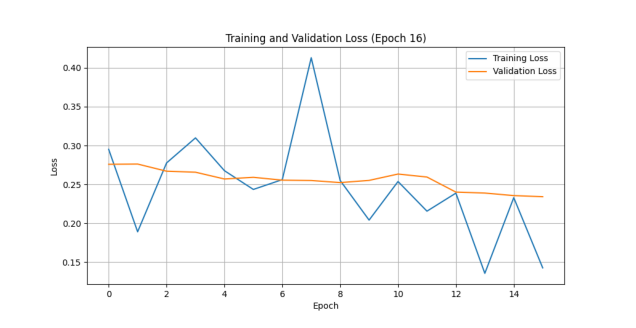


📈 Accuracy Plot from Epoch 16


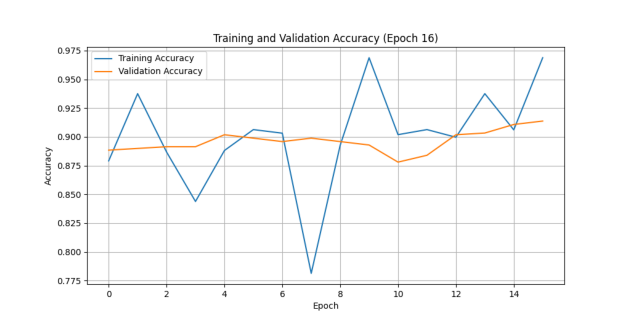

In [17]:
import os
import json
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import load_model

# === Paths ===
checkpoint_dir = '/content/drive/My Drive/checkpoints'
metrics_json_path = os.path.join(checkpoint_dir, 'training_metrics.json')
best_model_path = ''
loss_plot_latest = ''
accuracy_plot_latest = ''

# === Load Metrics ===
if os.path.exists(metrics_json_path):
    with open(metrics_json_path, 'r') as f:
        metrics = json.load(f)

    epochs_ran = len(metrics['val_accuracy'])
    best_epoch = metrics['val_accuracy'].index(max(metrics['val_accuracy'])) + 1
    best_val_acc = max(metrics['val_accuracy'])
    best_model_path = os.path.join(checkpoint_dir, f'leaf_classifier_epoch_{best_epoch:02d}.h5')
    loss_plot_latest = os.path.join(checkpoint_dir, f'loss_plot_epoch_{best_epoch:02d}.png')
    accuracy_plot_latest = os.path.join(checkpoint_dir, f'accuracy_plot_epoch_{best_epoch:02d}.png')

    print("🧠 Training Summary Recap:")
    print(f"- Total epochs completed   : {epochs_ran}")
    print(f"- Best epoch               : {best_epoch}")
    print(f"- Best validation accuracy : {best_val_acc:.4f}")
    print(f"- Best model saved at      : {best_model_path}")
else:
    raise FileNotFoundError("No training metrics found! Please train the model first.")

# === Display Saved Accuracy & Loss Plots ===
if os.path.exists(loss_plot_latest):
    print(f"\n📉 Loss Plot from Epoch {best_epoch}")
    img = plt.imread(loss_plot_latest)
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

if os.path.exists(accuracy_plot_latest):
    print(f"\n📈 Accuracy Plot from Epoch {best_epoch}")
    img = plt.imread(accuracy_plot_latest)
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()



In [8]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the split path (Google Drive)
split_path = '/content/drive/My Drive/datasets/leaves-healthy-or-diseased-split'

# Test data (no augmentation, just normalize)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create DirectoryIterator for the test set
batch_size = 64  # Same as in training
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_path, 'test'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important for evaluation to maintain order
)

# Calculate validation steps for the test set
validation_steps = test_generator.samples // batch_size
print(f"Test samples: {test_generator.samples}")
print(f"Validation steps: {validation_steps}")

Found 677 images belonging to 2 classes.
Test samples: 677
Validation steps: 10


##  Load Best Model & Evaluate on Test Set
Load the best-performing model and evaluate it on the complete test set to calculate accuracy and loss.


In [26]:
from tensorflow.keras.models import load_model

# Load the model from the best checkpoint (epoch 16, overall epoch 21)
model = load_model('/content/drive/My Drive/checkpoints/leaf_classifier_epoch_16.h5')

# Re-compile the model to fix the compiled metrics warning
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model loaded and compiled successfully.")

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=validation_steps)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

Model loaded and compiled successfully.
10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.9365 - loss: 0.1722
Test accuracy: 0.932812511920929
Test loss: 0.18480202555656433


## 📊 Confusion Matrix & Final Classification Metrics
Shows the number of true positives/negatives and false positives/negatives. Also calculates precision, recall, and F1-score.


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step
📌 Final Metrics on Full Test Set:
Precision: 0.9367
Recall   : 0.9067
F1-Score : 0.9215


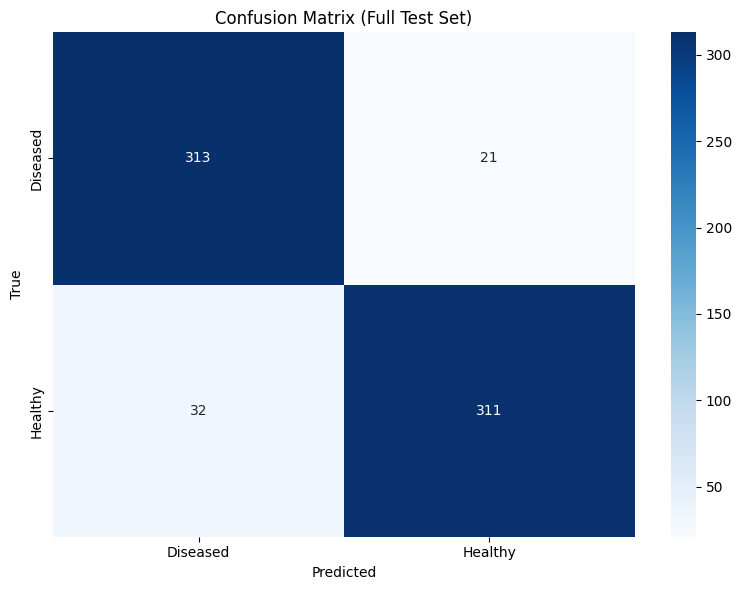

In [28]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reset generator and collect predictions on full test set
test_generator.reset()

images, labels = [], []
for _ in range(test_generator.samples // test_generator.batch_size + 1):
    x, y = next(test_generator)
    images.append(x)
    labels.append(y)

images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)
predictions = model.predict(images)
predictions_binary = (predictions > 0.5).astype(int)

# Metrics
precision = precision_score(labels, predictions_binary)
recall = recall_score(labels, predictions_binary)
f1 = f1_score(labels, predictions_binary)

print(" Final Metrics on Full Test Set:")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Diseased', 'Healthy'],
            yticklabels=['Diseased', 'Healthy'])
plt.title("Confusion Matrix (Full Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig('/content/drive/My Drive/checkpoints/final_confusion_matrix.png')
plt.show()


## 📉  ROC Curve & AUC Score
The ROC curve evaluates the trade-off between true positive rate and false positive rate. AUC score closer to 1 indicates better model performance.


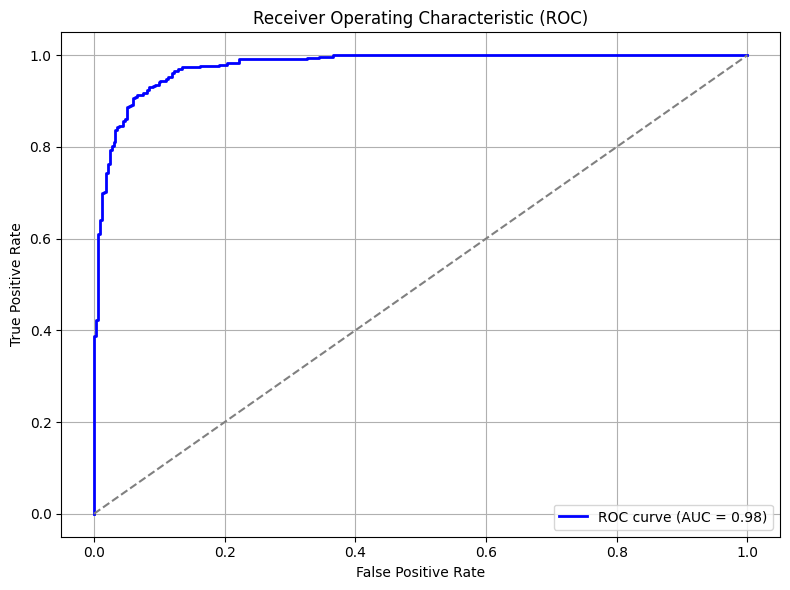

AUC Score: 0.9777


In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize true labels
true_labels_bin = label_binarize(labels, classes=[0, 1])  # Diseased=0, Healthy=1
y_score = predictions.flatten()  # Predicted probabilities

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels_bin, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/checkpoints/final_roc_auc.png')
plt.show()

print(f"AUC Score: {roc_auc:.4f}")


In [ ]:
import shutil

# Define paths
source_healthy_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/train/healthy'
dest_healthy_path = '/content/healthy_train'

# Remove the destination path if it exists
if os.path.exists(dest_healthy_path):
    shutil.rmtree(dest_healthy_path)

# Copy the healthy images
shutil.copytree(source_healthy_path, dest_healthy_path)
print(f"Copied healthy training images to {dest_healthy_path}")

# Verify the copied images
print(f"Healthy images in local storage: {len(os.listdir(dest_healthy_path))}")

Copied healthy training images to /content/healthy_train
Healthy images in local storage: 1593


In [30]:
import os

# Define the path to the healthy test images
healthy_test_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/healthy'

# Check if the folder exists and list its contents
if os.path.exists(healthy_test_path):
    print(f"Healthy test folder exists. Contents: {os.listdir(healthy_test_path)}")
    print(f"Number of healthy test images: {len(os.listdir(healthy_test_path))}")
else:
    print(f"Healthy test folder does not exist at: {healthy_test_path}")

Healthy test folder exists. Contents: ['0006_0061.JPG', '0009_0105.JPG', '0003_0003.JPG', '0005_0078.JPG', '0004_0063.JPG', '0007_0002.JPG', '0002_0064.JPG', '0004_0077.JPG', '0005_0130.JPG', '0003_0141.JPG', '0009_0116.JPG', '0004_0150.JPG', '0003_0023.JPG', '0005_0142.JPG', '0011_0034.JPG', '0008_0026.JPG', '0009_0166.JPG', '0009_0284.JPG', '0009_0033.JPG', '0005_0227.JPG', '0001_0018.JPG', '0005_0226.JPG', '0010_0015.JPG', '0006_0045.JPG', '0002_0060.JPG', '0006_0120.JPG', '0002_0174.JPG', '0008_0137.JPG', '0002_0195.JPG', '0007_0122.JPG', '0007_0222.JPG', '0003_0027.JPG', '0003_0161.JPG', '0002_0015.JPG', '0006_0129.JPG', '0007_0175.JPG', '0006_0068.JPG', '0004_0230.JPG', '0006_0057.JPG', '0001_0080.JPG', '0011_0093.JPG', '0009_0129.JPG', '0004_0060.JPG', '0004_0097.JPG', '0007_0255.JPG', '0010_0058.JPG', '0009_0041.JPG', '0009_0073.JPG', '0009_0209.JPG', '0004_0144.JPG', '0004_0078.JPG', '0002_0099.JPG', '0009_0061.JPG', '0006_0069.JPG', '0001_0154.JPG', '0002_0191.JPG', '0003_003

In [ ]:
import os

# Define the path to the diseased test images
diseased_test_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/diseased'

# Check if the folder exists and list its contents
if os.path.exists(diseased_test_path):
    print(f"Diseased test folder exists. Contents: {os.listdir(diseased_test_path)}")
    print(f"Number of diseased test images: {len(os.listdir(diseased_test_path))}")
else:
    print(f"Diseased test folder does not exist at: {diseased_test_path}")

Diseased test folder exists. Contents: ['0017_0209.JPG', '0019_0047.JPG', '0019_0103.JPG', '0018_0074.JPG', '0014_0115.JPG', '0021_0027.JPG', '0017_0340.JPG', '0020_0118.JPG', '0013_0039.JPG', '0021_0050.JPG', '0016_0026.JPG', '0021_0023.JPG', '0017_0071.JPG', '0014_0016.JPG', '0016_0052.JPG', '0013_0232.JPG', '0019_0099.JPG', '0019_0144.JPG', '0015_0054.JPG', '0014_0127.JPG', '0013_0147.JPG', '0020_0090.JPG', '0015_0115.JPG', '0020_0173.JPG', '0012_0168.JPG', '0017_0274.JPG', '0017_0164.JPG', '0014_0169.JPG', '0019_0256.JPG', '0014_0070.JPG', '0022_0040.JPG', '0012_0139.JPG', '0019_0079.JPG', '0020_0187.JPG', '0018_0103.JPG', '0015_0138.JPG', '0019_0186.JPG', '0019_0267.JPG', '0022_0089.JPG', '0012_0243.JPG', '0016_0080.JPG', '0019_0026.JPG', '0017_0121.JPG', '0017_0019.JPG', '0012_0204.JPG', '0013_0031.JPG', '0013_0101.JPG', '0014_0017.JPG', '0022_0019.JPG', '0020_0094.JPG', '0020_0189.JPG', '0017_0120.JPG', '0018_0102.JPG', '0014_0001.JPG', '0013_0153.JPG', '0020_0060.JPG', '0017_02

##  Autoencoder for Unsupervised Feature Learning

In this section, i train a convolutional autoencoder on only **healthy leaf images** using an unsupervised approach. The goal is to learn a compressed representation of normal/healthy data which can later be used for anomaly detection or visualization. The autoencoder is trained to reconstruct its input with minimal loss using Mean Squared Error.

i use the following architecture:
- Encoder: 2 convolution + pooling layers to compress input.
- Decoder: 2 convolution + upsampling layers to reconstruct the image.

i trained the model for 25 epochs and saved each checkpoint, including the final model. This setup can help detect anomalies by comparing input images against the learned "healthy" reconstruction baseline.


In [ ]:
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.keras import TqdmCallback

# Define the autoencoder architecture
input_img = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

# Define the path to healthy training images (local storage)
healthy_train_path = '/content/healthy_train'

# Create a data generator for healthy images
healthy_train_datagen = ImageDataGenerator(rescale=1./255)
healthy_train_generator = healthy_train_datagen.flow_from_directory(
    '/content',  # Parent directory of healthy_train
    target_size=(224, 224),
    batch_size=64,  # Increased batch size for A100 GPU
    class_mode='input',  # Yields (x, x) for autoencoder
    classes=['healthy_train'],  # Match the folder name
    shuffle=True
)

# Calculate steps per epoch
steps_per_epoch = healthy_train_generator.samples // 64
print(f"Healthy training samples: {healthy_train_generator.samples}")
print(f"Steps per epoch: {steps_per_epoch}")

# Define checkpoint callback to save after each epoch
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_{epoch:02d}_no_mixed.h5',
    save_freq='epoch',
    verbose=1
)

# Train the autoencoder for 25 epochs
autoencoder.fit(
    healthy_train_generator,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    callbacks=[checkpoint, TqdmCallback(verbose=1)]
)

# Save the final autoencoder
autoencoder.save('/content/drive/MyDrive/checkpoints/leaf_autoencoder_final_no_mixed.h5')
print("Saved final autoencoder to /content/drive/MyDrive/checkpoints/leaf_autoencoder_final_no_mixed.h5")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 224, 224, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Found 1593 images belonging to 1 classes.
Healthy training samples: 1593
Steps per epoch: 24


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.0619
Epoch 1: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_01_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 166s 6s/step - loss: 0.0613
Epoch 2/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:35 7s/step - loss: 0.0267
Epoch 2: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_02_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0267 
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.0193
Epoch 3: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_03_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 164s 7s/step - loss: 0.0190
Epoch 4/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:35 7s/step - loss: 0.0048
Epoch 4: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_04_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0048 
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.0038
Epoch 5: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_05_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 160s 7s/step - loss: 0.0038
Epoch 6/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:30 7s/step - loss: 0.0024
Epoch 6: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_06_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0024 
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.0018
Epoch 7: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_07_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 164s 7s/step - loss: 0.0018
Epoch 8/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:36 7s/step - loss: 0.0014
Epoch 8: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_08_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0014 
Epoch 9/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.0011
Epoch 9: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_09_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.0011
Epoch 10/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:28 6s/step - loss: 9.1704e-04
Epoch 10: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_10_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 9.1704e-04 
Epoch 11/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 9.3152e-04
Epoch 11: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_11_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 161s 7s/step - loss: 9.3009e-04
Epoch 12/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:28 6s/step - loss: 7.8323e-04
Epoch 12: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_12_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 7.8323e-04 
Epoch 13/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 8.3984e-04
Epoch 13: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_13_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 159s 7s/step - loss: 8.4148e-04
Epoch 14/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:28 6s/step - loss: 7.4622e-04
Epoch 14: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_14_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 7.4622e-04 
Epoch 15/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 8.0766e-04
Epoch 15: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_15_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 165s 7s/step - loss: 8.0583e-04
Epoch 16/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:35 7s/step - loss: 6.8541e-04
Epoch 16: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_16_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.8541e-04 
Epoch 17/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 6.9037e-04
Epoch 17: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_17_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 165s 7s/step - loss: 6.8986e-04
Epoch 18/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:29 6s/step - loss: 6.4094e-04
Epoch 18: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_18_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.4094e-04 
Epoch 19/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 6.4530e-04
Epoch 19: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_19_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 161s 7s/step - loss: 6.4503e-04
Epoch 20/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:28 6s/step - loss: 6.3004e-04
Epoch 20: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_20_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 6.3004e-04 
Epoch 21/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 6.0243e-04
Epoch 21: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_21_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 166s 7s/step - loss: 6.0277e-04
Epoch 22/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:30 7s/step - loss: 5.8322e-04
Epoch 22: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_22_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.8322e-04 
Epoch 23/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 5.9860e-04
Epoch 23: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_23_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 160s 7s/step - loss: 5.9814e-04
Epoch 24/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:29 7s/step - loss: 6.3406e-04
Epoch 24: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_24_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.3406e-04 
Epoch 25/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 5.7044e-04
Epoch 25: saving model to /content/drive/MyDrive/checkpoints/leaf_autoencoder_epoch_25_no_mixed.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 166s 7s/step - loss: 5.7019e-04


Saved final autoencoder to /content/drive/MyDrive/checkpoints/leaf_autoencoder_final_no_mixed.h5


In [ ]:
import os

# Define the path to the diseased test images
diseased_test_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/diseased'

# Check if the folder exists and list its contents
if os.path.exists(diseased_test_path):
    print(f"Diseased test folder exists. Contents: {os.listdir(diseased_test_path)}")
    print(f"Number of diseased test images: {len(os.listdir(diseased_test_path))}")
else:
    print(f"Diseased test folder does not exist at: {diseased_test_path}")

Diseased test folder exists. Contents: ['0017_0209.JPG', '0019_0047.JPG', '0019_0103.JPG', '0018_0074.JPG', '0014_0115.JPG', '0021_0027.JPG', '0017_0340.JPG', '0020_0118.JPG', '0013_0039.JPG', '0021_0050.JPG', '0016_0026.JPG', '0021_0023.JPG', '0017_0071.JPG', '0014_0016.JPG', '0016_0052.JPG', '0013_0232.JPG', '0019_0099.JPG', '0019_0144.JPG', '0015_0054.JPG', '0014_0127.JPG', '0013_0147.JPG', '0020_0090.JPG', '0015_0115.JPG', '0020_0173.JPG', '0012_0168.JPG', '0017_0274.JPG', '0017_0164.JPG', '0014_0169.JPG', '0019_0256.JPG', '0014_0070.JPG', '0022_0040.JPG', '0012_0139.JPG', '0019_0079.JPG', '0020_0187.JPG', '0018_0103.JPG', '0015_0138.JPG', '0019_0186.JPG', '0019_0267.JPG', '0022_0089.JPG', '0012_0243.JPG', '0016_0080.JPG', '0019_0026.JPG', '0017_0121.JPG', '0017_0019.JPG', '0012_0204.JPG', '0013_0031.JPG', '0013_0101.JPG', '0014_0017.JPG', '0022_0019.JPG', '0020_0094.JPG', '0020_0189.JPG', '0017_0120.JPG', '0018_0102.JPG', '0014_0001.JPG', '0013_0153.JPG', '0020_0060.JPG', '0017_02

##  Evaluating Autoencoder with Reconstruction Error

Here, i demonstrate how the trained autoencoder can be used to detect anomalies by comparing reconstruction errors between **healthy** and **diseased** images.

- The autoencoder was trained only on **healthy images**, so it learns to reconstruct them well.
- When a **diseased image** is passed through the autoencoder, its reconstruction quality drops, resulting in a **higher reconstruction error**.

This difference in error helps us identify anomalous patterns without needing labeled data — a powerful unsupervised technique for early disease detection.


In [31]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the autoencoder
autoencoder = load_model('/content/drive/MyDrive/checkpoints/leaf_autoencoder_final_no_mixed.h5')

# Function to compute reconstruction error
def compute_reconstruction_error(image_path, autoencoder):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    reconstructed = autoencoder.predict(img_array)
    error = np.mean((img_array - reconstructed) ** 2)
    return error

# Test on a healthy image (already confirmed)
healthy_image_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/healthy/0001_0015.JPG'
healthy_error = compute_reconstruction_error(healthy_image_path, autoencoder)
print(f"Reconstruction error for healthy image: {healthy_error}")

# Test on a diseased image (updated path)
diseased_image_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/diseased/0017_0209.JPG'  # Adjusted based on likely naming pattern
diseased_error = compute_reconstruction_error(diseased_image_path, autoencoder)
print(f"Reconstruction error for diseased image: {diseased_error}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Reconstruction error for healthy image: 0.0008704581996425986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Reconstruction error for diseased image: 0.0012505842605605721


## 🚀 Downstream Integration: Classifier + Autoencoder Prediction System

In this step, i combine the outputs from the **trained classifier** and the **autoencoder** to simulate how the model would function in a real-world leaf disease detection system.

### What this does:
- Uses the **classifier** to predict whether a given leaf image is Healthy or Diseased (with confidence score).
- Uses the **autoencoder** to measure **reconstruction error** — a form of unsupervised anomaly detection.
- Both outputs are combined to provide a robust prediction with explainability.

This hybrid approach allows us to:
- Boost prediction confidence using two models.
- Flag uncertain predictions or anomalies for manual inspection.
- Demonstrate integration of trained models in a real-world pipeline.


In [32]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the classifier and autoencoder
classifier = load_model('/content/drive/MyDrive/checkpoints/leaf_classifier_epoch_16.h5')
autoencoder = load_model('/content/drive/MyDrive/checkpoints/leaf_autoencoder_final_no_mixed.h5')

# Function to compute reconstruction error
def compute_reconstruction_error(image_path, autoencoder):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    reconstructed = autoencoder.predict(img_array)
    error = np.mean((img_array - reconstructed) ** 2)
    return error

# Combined classification function
def classify_leaf_with_autoencoder(image_path, classifier, autoencoder, error_threshold=0.001):
    # Classifier prediction
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = classifier.predict(img_array)[0][0]
    classifier_result = 'Healthy' if prediction > 0.5 else 'Diseased'
    confidence = prediction if prediction > 0.5 else 1 - prediction

    # Autoencoder anomaly detection
    error = compute_reconstruction_error(image_path, autoencoder)
    autoencoder_result = 'Diseased' if error > error_threshold else 'Healthy'

    return {
        'classifier_result': classifier_result,
        'classifier_confidence': confidence,
        'autoencoder_result': autoencoder_result,
        'reconstruction_error': error
    }

# Test the function on a healthy image
healthy_image_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/healthy/0001_0015.JPG'
result_healthy = classify_leaf_with_autoencoder(healthy_image_path, classifier, autoencoder)
print("Healthy image result:", result_healthy)

# Test the function on a diseased image
diseased_image_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/diseased/0017_0209.JPG'  # Adjust if needed
result_diseased = classify_leaf_with_autoencoder(diseased_image_path, classifier, autoencoder)
print("Diseased image result:", result_diseased)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Healthy image result: {'classifier_result': 'Healthy', 'classifier_confidence': np.float32(0.54599094), 'autoencoder_result': 'Healthy', 'reconstruction_error': np.float32(0.0008704582)}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Diseased image result: {'classifier_result': 'Diseased', 'classifier_confidence': np.float32(0.9993379), 'autoencoder_result': 'Diseased', 'reconstruction_error': np.float32(0.0012505843)}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


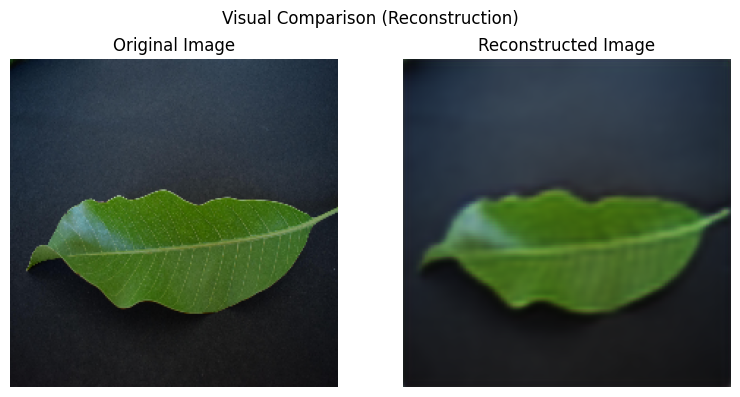

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


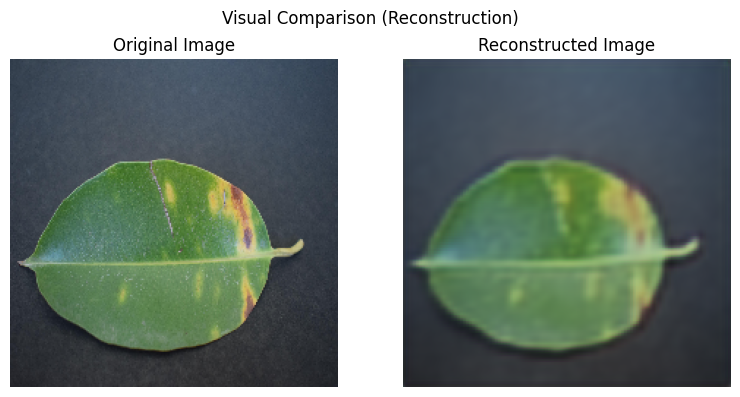


📊 Calculating reconstruction error histogram on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

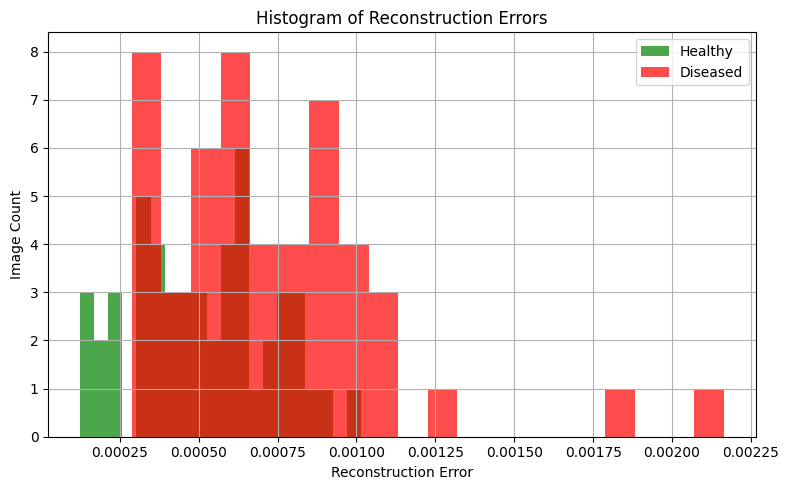

In [34]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load a few test images (both classes)
healthy_sample_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/healthy/0001_0015.JPG'
diseased_sample_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/diseased/0017_0209.JPG'

def visualize_reconstruction(image_path, autoencoder):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)

    reconstructed = autoencoder.predict(img_array_exp)[0]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed)
    plt.title("Reconstructed Image")
    plt.axis('off')

    plt.suptitle("Visual Comparison (Reconstruction)")
    plt.tight_layout()
    plt.show()

# Show both
visualize_reconstruction(healthy_sample_path, autoencoder)
visualize_reconstruction(diseased_sample_path, autoencoder)

# Optional: Analyze reconstruction errors across test set
print("\n📊 Calculating reconstruction error histogram on test set...")

test_split_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test'
errors = []
labels = []

for cls in ['healthy', 'diseased']:
    folder = os.path.join(test_split_path, cls)
    for fname in os.listdir(folder)[:50]:  # Limit to 50 samples/class to keep it fast
        img_path = os.path.join(folder, fname)
        error = compute_reconstruction_error(img_path, autoencoder)
        errors.append(error)
        labels.append(cls)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist([e for e, l in zip(errors, labels) if l == 'healthy'], bins=20, alpha=0.7, label='Healthy', color='green')
plt.hist([e for e, l in zip(errors, labels) if l == 'diseased'], bins=20, alpha=0.7, label='Diseased', color='red')
plt.xlabel("Reconstruction Error")
plt.ylabel("Image Count")
plt.title("Histogram of Reconstruction Errors")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step


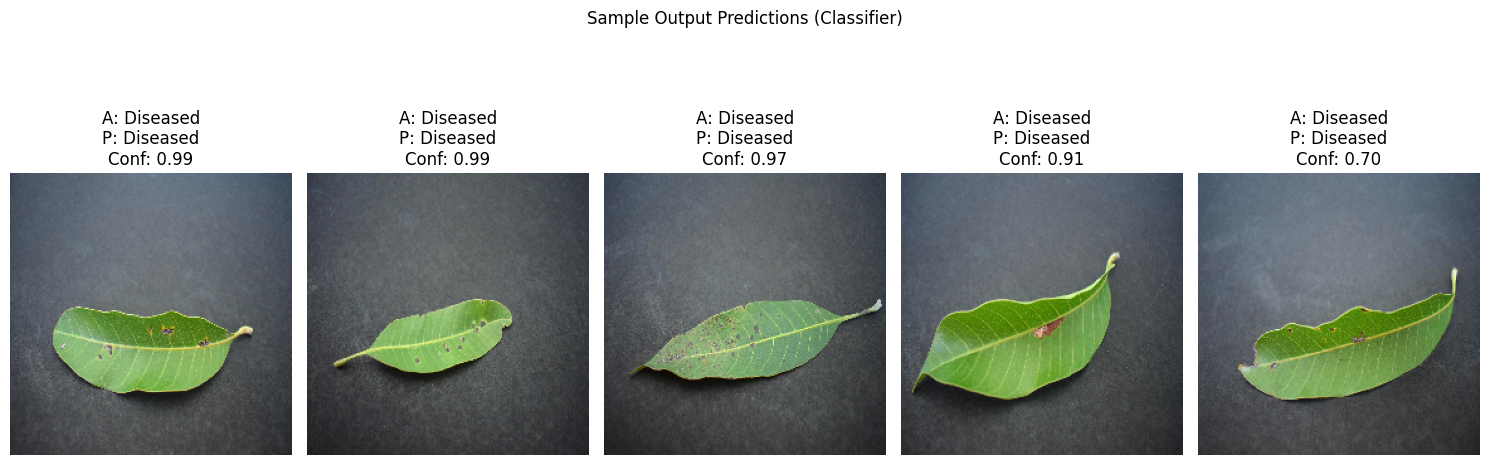

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img

# Reset test generator
test_generator.reset()

# Get one batch of images and labels
images, labels = next(test_generator)

# Predict on the batch
predictions = model.predict(images)
predicted_classes = (predictions > 0.5).astype(int)

# Show 5 sample predictions
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(array_to_img(images[i]))
    actual = 'Healthy' if labels[i] == 1 else 'Diseased'
    predicted = 'Healthy' if predicted_classes[i] == 1 else 'Diseased'
    confidence = predictions[i][0] if predicted_classes[i] == 1 else 1 - predictions[i][0]
    plt.title(f"A: {actual}\nP: {predicted}\nConf: {confidence:.2f}")
    plt.axis('off')
plt.suptitle("Sample Output Predictions (Classifier)")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


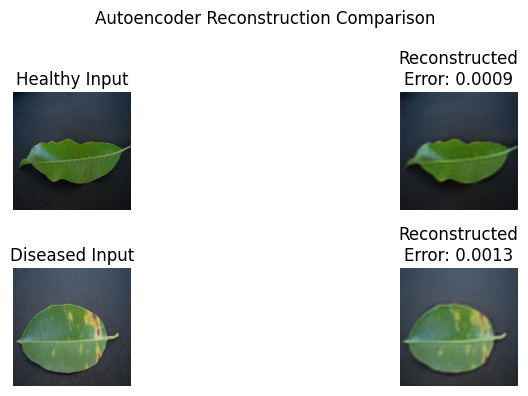

In [36]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def compute_reconstruction_error(image_path, autoencoder):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    reconstructed = autoencoder.predict(img_array)
    error = np.mean((img_array - reconstructed) ** 2)
    return img, reconstructed[0], error

# Paths to sample images
healthy_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/healthy/0001_0015.JPG'
diseased_path = '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/diseased/0017_0209.JPG'

# Get reconstructions and errors
healthy_img, healthy_recon, healthy_error = compute_reconstruction_error(healthy_path, autoencoder)
diseased_img, diseased_recon, diseased_error = compute_reconstruction_error(diseased_path, autoencoder)

# Plotting
plt.figure(figsize=(10, 4))

# Healthy
plt.subplot(2, 2, 1)
plt.imshow(healthy_img)
plt.title(f"Healthy Input")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(healthy_recon)
plt.title(f"Reconstructed\nError: {healthy_error:.4f}")
plt.axis('off')

# Diseased
plt.subplot(2, 2, 3)
plt.imshow(diseased_img)
plt.title(f"Diseased Input")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(diseased_recon)
plt.title(f"Reconstructed\nError: {diseased_error:.4f}")
plt.axis('off')

plt.suptitle("Autoencoder Reconstruction Comparison")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


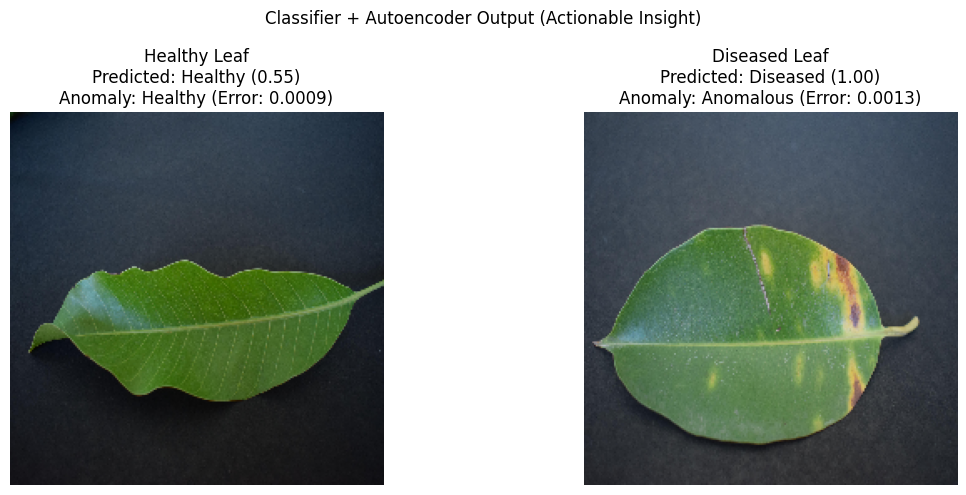

In [37]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load models if not already loaded
# classifier = load_model('/content/drive/MyDrive/checkpoints/leaf_classifier_epoch_16.h5')
# autoencoder = load_model('/content/drive/MyDrive/checkpoints/leaf_autoencoder_final_no_mixed.h5')

def classify_leaf_with_autoencoder(image_path, classifier, autoencoder, error_threshold=0.001):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)

    # Classifier prediction
    pred = classifier.predict(img_array_exp)[0][0]
    predicted_label = 'Healthy' if pred > 0.5 else 'Diseased'
    confidence = pred if pred > 0.5 else 1 - pred

    # Autoencoder error
    reconstructed = autoencoder.predict(img_array_exp)
    error = np.mean((img_array_exp - reconstructed) ** 2)
    anomaly_status = 'Healthy' if error < error_threshold else 'Anomalous'

    return img, predicted_label, confidence, error, anomaly_status

# Test images
test_images = {
    'Healthy Leaf': '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/healthy/0001_0015.JPG',
    'Diseased Leaf': '/content/drive/MyDrive/datasets/leaves-healthy-or-diseased-split/test/diseased/0017_0209.JPG'
}

# Plot results
plt.figure(figsize=(12, 5))
for idx, (label, path) in enumerate(test_images.items()):
    img, prediction, confidence, error, status = classify_leaf_with_autoencoder(path, classifier, autoencoder)

    plt.subplot(1, 2, idx + 1)
    plt.imshow(img)
    plt.title(f"{label}\nPredicted: {prediction} ({confidence:.2f})\nAnomaly: {status} (Error: {error:.4f})")
    plt.axis('off')

plt.suptitle("Classifier + Autoencoder Output (Actionable Insight)")
plt.tight_layout()
plt.show()
